### Code modified from: https://www.tensorflow.org/tutorials/generative/style_transfer

In [ ]:
%pip install --upgrade imageio
%pip install --upgrade scikit-image
%pip install ipywidgets

In [25]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
# Image processing functions

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
# Define a function to load an image and limit its max dims to 512 pixels
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [3]:
style_path = 'swansreflectingelephants.jpg'
content_path = 'winterupsidedown.jpg'
print(content_path)

winterupsidedown.jpg


In [27]:
output = 'color_shift.jpg'
orgcontent = content_path
cp = 'match'

%run -i lum-transfer-indents-fixed.py --content_image {content_path} --style_image {style_path} --output_image {output} \
--output_style_image {output} --org_content {orgcontent} --cp_mode {cp}

<Figure size 864x864 with 0 Axes>

In [28]:
style_path_with_cc = output

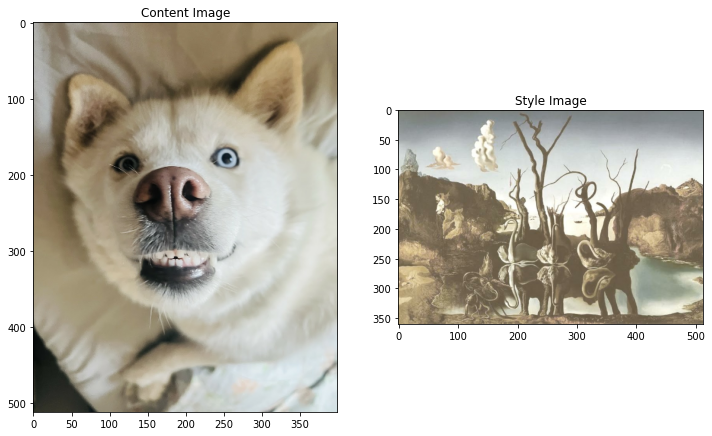

In [29]:
content_image = load_img(content_path)
style_image = load_img(style_path_with_cc) # load image with color correction to preserve colors of content image or without to make it look more stained glass like

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


In [8]:
# Now load a `VGG19` without the classification head, and list the layer names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 5s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
# Choose intermediate layers from the network to represent the style and content of the image:

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

In [10]:
# Build a VGG19 model that returns a list of intermediate layer outputs
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [11]:
# And to create the model:
style_extractor = vgg_layers(style_layers) # model
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 361, 512, 64)
  min:  0.0
  max:  852.8865
  mean:  27.557764

block2_conv1
  shape:  (1, 180, 256, 128)
  min:  0.0
  max:  2975.8262
  mean:  156.7291

block3_conv1
  shape:  (1, 90, 128, 256)
  min:  0.0
  max:  7580.0938
  mean:  146.21243

block4_conv1
  shape:  (1, 45, 64, 512)
  min:  0.0
  max:  16298.188
  mean:  574.59174

block5_conv1
  shape:  (1, 22, 32, 512)
  min:  0.0
  max:  2117.5115
  mean:  41.781128



## Calculate style

The content of an image is represented by the values of the intermediate feature maps. Calculate a Gram Matrix.

This can be implemented concisely using the `tf.linalg.einsum` function:

In [12]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


In [13]:
# Build a model that returns the style and content tensors.
class StyleContentModel(tf.keras.models.Model): 
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [14]:
# When called on an image, this model returns the gram matrix (style) of the `style_layers` 
# and content of the `content_layers`:
extractor = StyleContentModel(style_layers, content_layers) # model

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.010087814
    max:  42034.523
    mean:  175.04836

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  48539.336
    mean:  5382.3203

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  155131.38
    mean:  5044.886

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1122137.2
    mean:  87436.51

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  48123.406
    mean:  832.99603

Contents:
   block5_conv2
    shape:  (1, 32, 25, 512)
    min:  0.0
    max:  928.05505
    mean:  10.612815


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

In [15]:
# Set your style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [16]:
# Define a `tf.Variable` to contain the image to optimize. To make this quick, 
#initialize it with the content image (the `tf.Variable` must be the same shape as the content image):
image = tf.Variable(content_image)

In [17]:
# Since this is a float image, define a function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [18]:
# To optimize this, use a weighted combination of the two losses to get the total loss:
style_weight=1e-2
content_weight=1e4

In [19]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [20]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
  return x_var, y_var

In [21]:
tf.image.total_variation(image).numpy()

array([14861.404], dtype=float32)

In [22]:
# Choose a weight for the `total_variation_loss` and include it in the train_step function:
total_variation_weight=30
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [23]:
# Initialize the image-variable and the optimizer:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

## Re-run the optimization

....................................................................................................

Train step: 100
....................................................................................................

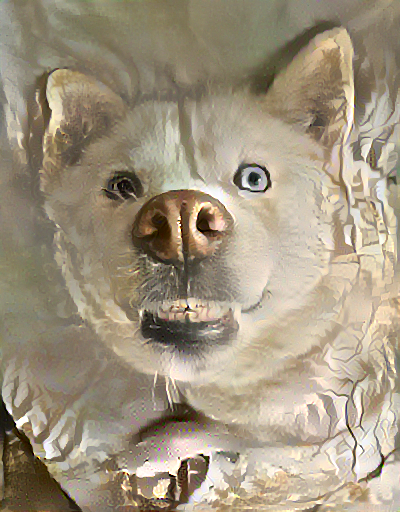

Train step: 200
....................................................................................................

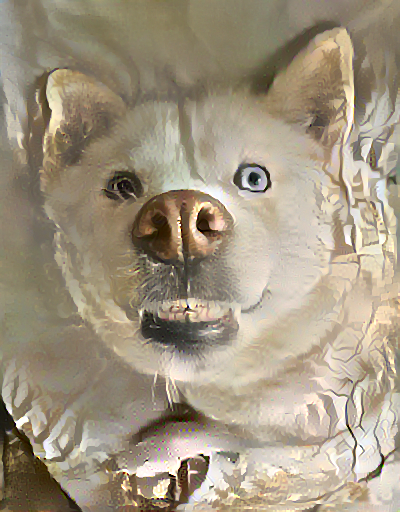

Train step: 300
....................................................................................................

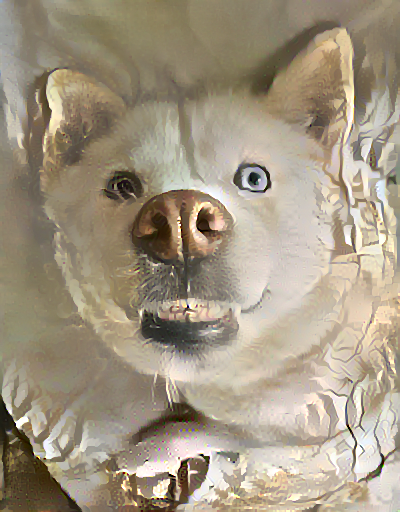

Train step: 400
....................................................................................................

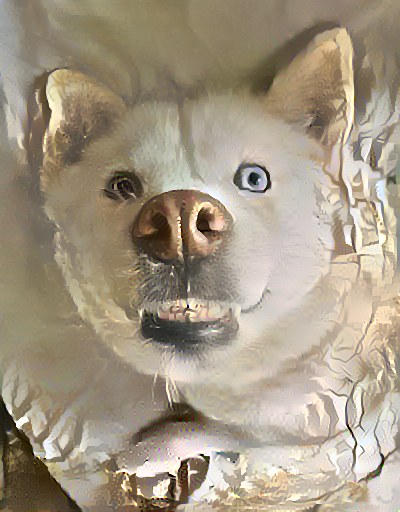

Train step: 500
....................................................................................................

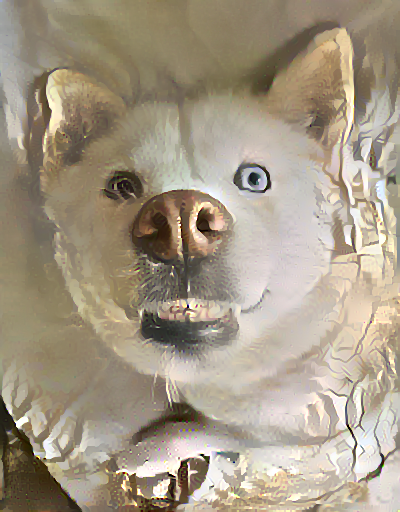

Train step: 600
....................................................................................................

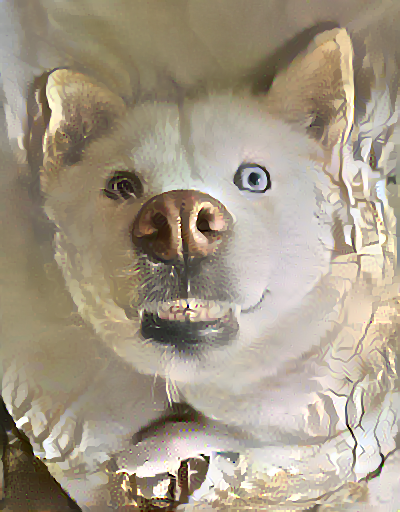

Train step: 700
....................................................................................................

Train step: 800
....................................................................................................

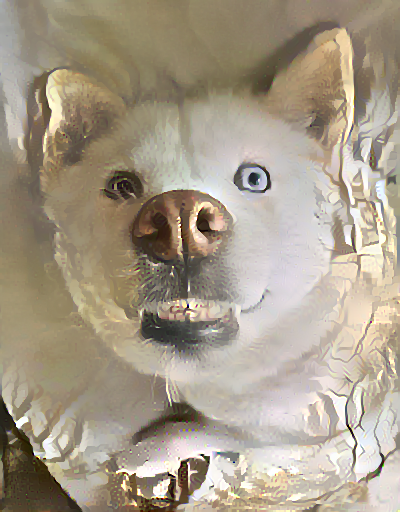

Train step: 900
....................................................................................................

Train step: 1000
Total time: 12.0


In [30]:
# Run the optimization
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  # display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [31]:
# Save the result
# file_name = 'stylized-image-originalcolor.png'
file_name = 'stylized-image-stylecolor.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>